In [3]:
# *** PROBLEM 2 *** #
import pandas as pd
import numpy as np 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import seaborn as sns

In [3]:
# Reading in data
train_df_ori = pd.read_csv('train.csv')
test_df_ori = pd.read_csv('test.csv')

# Saving passenger id's for kaggle submission
passenger_ids = test_df_ori["PassengerId"]

train_df = train_df_ori.copy()
test_df = test_df_ori.copy()


In [4]:
# BEGINNING PREPROCESSING - This preprocessing pipeline is heavily inspired by 
# the example code from the lecture 5 jupyter notebook. 

# Dropping unimportant and poor features. These features are either
# irrelevant to survival or in difficult to manage formats
irrelevant_feats = ['PassengerId', 'Name', 'Cabin', 'Ticket'] 
train_df.drop(irrelevant_feats, axis=1, inplace=True)
test_df.drop(irrelevant_feats, axis=1, inplace=True)

In [5]:
# Imputing - This step will fill in blank or missing values in the dataset

numerical_feats = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_feats = ["Sex", "Embarked"]

# We will replace missing numerical values with the median for that feature
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# We will replace missing categorical values with the mode for that feature 
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# For every column other than "Survived", search for missing values
# and replace them using the corresponding imputer 
for column in train_df.columns[1:]: 
    if (column in numerical_feats): 
        fill = num_imputer.fit_transform(train_df[column].values.reshape(-1,1))
        train_df[column] = fill.ravel()
        fill = num_imputer.transform(test_df[column].values.reshape(-1,1))
        test_df[column] = fill.ravel()
    else: 
        fill = cat_imputer.fit_transform(train_df[column].values.reshape(-1,1))
        train_df[column] = fill.ravel()
        fill = cat_imputer.transform(test_df[column].values.reshape(-1,1))
        test_df[column] = fill.ravel()



In [6]:
# One hot encoding 
def dataframe_onehotencoder(encoder, df, columns_names, fit_transform=True):
    '''
    This is a helper function to apply sklearn onehotencoder function
    on multiple columns of a data frame.

    Args:
        encoder: initialized OneHotEncoder
        df: Pandas dataframe with data
        columns_names: names of the columns in dataframe to encode
        fit_transform: True when the encoder is seeing the categorical data for the first time; False otherwise.
    
    Returns:
        dataframe: with one-hot-encoded columns
    '''
    
    # One-hot-encode the columns in column names
    if(fit_transform):
        data = encoder.fit_transform(df[columns_names])
    else:
        data = encoder.transform(df[columns_names])

    # Convert data to a dataframe
    df2 = pd.DataFrame(data, columns=encoder.get_feature_names_out(columns_names), index=df.index)
    
    # Recreate original dataframe
    df3 = pd.concat([df.drop(columns_names, axis=1), df2], axis=1)
    
    # Return
    return df3 


In [7]:
encoder = OneHotEncoder(drop='first', sparse_output=False) # drops first feature to avoid colinear features
df_OHE = dataframe_onehotencoder(encoder=encoder, df=train_df, columns_names=categorical_feats, fit_transform=True)

train_df = dataframe_onehotencoder(encoder=encoder, df=train_df, 
                                   columns_names=categorical_feats, fit_transform=True)
test_df = dataframe_onehotencoder(encoder=encoder, df=test_df, 
                                  columns_names=categorical_feats, fit_transform=False)

In [8]:
def dataframe_normalization(transformer, df, fit_transform=True):
    '''
    This is a helper function to normalize the dataset features using the ColumnTransformer class.

    Args:
        transformer: initialized ColumnTransformer
        df: Pandas dataframe with the data
        fit_transform: True when the transformer is seeing the data for the first time; False otherwise.
    
    Returns:
        dataframe: with specific normalized columns
    '''
    
    # Copy data
    df2 = df.copy()

    if(fit_transform):
        data = transformer.fit_transform(df2)
    else:
        data = transformer.transform(df2)

    # Add normalized data to dataframe
    for index, column in enumerate(transformer.get_feature_names_out()):
        df2[column] = data[:,index]
        
    # Return
    return df2 

In [9]:
# Using ColumnTransformer to apply specific normalization to each column in our data
norm_scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), ['Pclass', 'Parch']),  
        ('standard', StandardScaler(), ['Age', 'SibSp', 'Fare'])
    ], verbose_feature_names_out=False
)

# Normalize data (Treat all features the same)
train_df2 = dataframe_normalization(transformer=norm_scaler, df=train_df, fit_transform=True)
test_df2 = dataframe_normalization(transformer=norm_scaler, df=test_df, fit_transform=False)

In [10]:
rng1 = np.random.RandomState(seed=45) # seeding our rng

y = train_df2['Survived'].values # extracting targets
X = train_df2.iloc[:,1:].values # extracting parameters 

# splitting data to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=rng1, stratify=y)

# ENDING PREPROCESSING - Data is now ready for model training


In [11]:
# SKLEARN MODEL

log_classifier = LogisticRegression(max_iter=1000, random_state=rng1)
log_classifier.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,RandomState(M... 0x1B36275AC40
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [12]:
# Predictions from SKlearn model
y_val_pred = log_classifier.predict(X_val)
y_val_probs = log_classifier.predict_proba(X_val)[:, 1]  # probability of "Survived" 

# Metrics
acc = accuracy_score(y_val, y_val_pred)
loss = log_loss(y_val, y_val_probs)
cm = confusion_matrix(y_val, y_val_pred)

print("Validation Accuracy:", acc)
print("Validation Log Loss (Binary Cross Entropy):", loss)
print("Confusion Matrix:\n", cm)


Validation Accuracy: 0.7985074626865671
Validation Log Loss (Binary Cross Entropy): 0.44009547402646
Confusion Matrix:
 [[75  8]
 [19 32]]


In [13]:
# SCRATCH MODEL

# TRAINING AND INTERNAL FUNCTIONS 

# Computes the sigmoid function
def sigmoid(z): 
    return (1 / (1 + np.exp(-z)))

# Initializes the starting parameters w and b with an optional seed 
def initialize_params(m_features, seed=None): 
    if (seed is not None):
        np.random.seed(seed)
    
    w = np.random.rand(m_features, 1)
    b = 0

    # returns parameters 
    return w, b

# Computes the linear combination of featurs and uses the sigmoid
# to calculate probabilities of survival
def forward(X, w, b): 
    z = X.dot(w) + b
    y_hat = sigmoid(z)

    # returns raw score prediction and normalized [0,1] prediction
    return z, y_hat

# Uses binary cross entropy to calculate the log-loss of the training
def compute_cost(y, y_hat, w):
    #Force shapes
    y_hat = y_hat.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Assumes LogLoss
    eps = 1e-12
    cost = -(np.dot(y.T,np.log(y_hat+eps)) + np.dot(1-y.T,np.log(1-y_hat+eps))) / len(y)

    # returns error as a scalar 
    return np.squeeze(cost)

# Computes gradients for our gradient descent algorithm 
def compute_gradients(X, y, y_hat, w, reg_lambda=0.0): 
    #Force shapes
    y_hat = y_hat.reshape(-1,1)
    y = y.reshape(-1,1)

    # number of samples
    n = len(y)

    # finding gradients of b and w respectively 
    db = (1/n)*np.sum(y_hat-y)
    dw = (1/n)*X.T.dot(y_hat-y)

    # returns our gradients for w and b
    return dw, db

# Updates parameters using calculated gradients and provided learning rate 
def update_params(w, b, dw, db, lr): 
    w = w - lr * dw
    b = b - lr * db

    # returns updated w and b params 
    return w, b

# Core training loop 
def train(X, y, lr, n_epochs, X_val=None, y_val=None, seed=None): 
    # initialize our parameters 
    samples, features = X.shape
    w, b = initialize_params(features, seed)

    # Initialize two lists to track loss across epochs 
    train_losses = []
    val_losses = []
    
    # For each training iteration
    for i in range(n_epochs): 
        z, y_hat = forward(X, w, b) # Make one forward pass
        cost = compute_cost(y, y_hat, w) # Calculate error
        train_losses.append(cost) # Track error
        dw, db = compute_gradients(X, y, y_hat, w) # Perform gradient descent 
        w, b = update_params(w, b, dw, db, lr) # Update our parameters 

        # If we have a provided validation set
        if (X_val is not None and y_val is not None): 
            z_val, y_hat_val = forward(X_val, w, b) # Perform one forward pass
            # Calculate and track error on validation set
            val_cost = compute_cost(y_val, y_hat_val, w) 
            val_losses.append(val_cost)
    
    # Return our trained parameters and our loss history 
    return w, b, train_losses, val_losses


# PREDICTION FUNCTIONS - USE AFTER TRAINING 

# Calculate probability of survival for a sample 
# EXPECTS TRAINED PARAMETERS
def predict_prob(X, w, b): 
    z, y_hat = forward(X, w, b)

    # returns probability of survival 
    return y_hat

# Predict wether a sample survived, returns a binary int (1 for lived, 0 for died)
# EXPECTS TRAINED PARAMETERS
def predict(X, w, b): 
    prob = predict_prob(X, w, b)
    
    # return boolean for survival as an integer 
    return (prob >= 0.5).astype(int)



In [14]:
# Training and validating scratch model 
w, b, training_loss, val_loss = train(X_train, y_train, .0275, 1500, X_val, y_val, 45)

# Validating scratch model
y_val_prob = predict_prob(X_val, w, b)
y_val_prediction = predict(X_val, w, b)

print("Val accuracy:", accuracy_score(y_val, y_val_prediction))
print("Val log loss:", log_loss(y_val, y_val_prob))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_prediction))

Val accuracy: 0.8134328358208955
Val log loss: 0.4947885571796464
Confusion matrix:
 [[78  5]
 [20 31]]


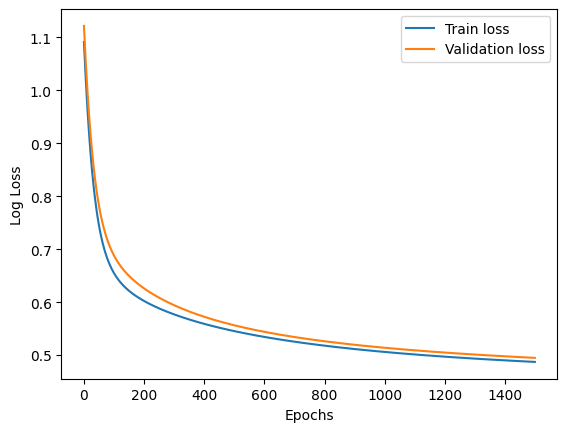

In [15]:
# Plotting loss over epochs 
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

In [16]:
# TESTING

# SCRATCH TESTING
X_test = test_df2.values
y_test_pred_scratch = predict(X_test, w, b).flatten()

# Build submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred_scratch.astype(int)
})

# Save file
submission.to_csv("scratch_submission.csv", index=False)

# SKLEARN TESTING
y_test_pred_sk = log_classifier.predict(X_test)

# Build submission DataFrame
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred_sk.astype(int)
})

# Save file
submission.to_csv("sklearn_submission.csv", index=False)

HW2 START

In [19]:
def PandasOneHotEncodeNumpy(DataFrame, Columns): 
    df = DataFrame.copy() #create a copy to preserve original df

    column_names = []
    # loop through provided columns and convert indices to column names for use
    for i in Columns: 
        if (isinstance(i, int)): 
            column_names.append(df.columns[i])
        else: 
            column_names.append(i)

    new_column_names = []
    # loop through all columns 
    for col in column_names: 
        # get all categories within the column 
        values = df[col].unique().tolist()

        # for all but the first category (ie. drop the first category)
        for val in values[1:]:
            new_col_name = f"{col}_{val}" #create new name
            new_column_names.append(new_col_name) #save new name

            # create a new column with the new title. Then we must assign each sample 
            # a value in this column. If the original categorical column's value for the sample is 
            # equal to the category we are building a column for this comparison will return
            # true, converted to 1, otherwise it will return false, converted to 0. 
            df[new_col_name] = (df[col] == val).astype(np.float32)
        
        df = df.drop(columns = [col]) #drop the original categorical column

    #convert df to matrix and return 
    numpy_mat = df.to_numpy(dtype=np.float32)
    return numpy_mat, new_column_names

In [21]:
data = pd.DataFrame({
    'Color': ['Red', 'Blue', 'Green', 'Red'],
    'Size': ['S', 'M', 'L', 'M'],
    'Price': [10, 20, 30, 40]
})

Columns = [0, 'Size']
matrix, column_names = PandasOneHotEncodeNumpy(data, Columns)

print(column_names)
print(matrix)

['Color_Blue', 'Color_Green', 'Size_M', 'Size_L']
[[10.  0.  0.  0.  0.]
 [20.  1.  0.  1.  0.]
 [30.  0.  1.  0.  1.]
 [40.  0.  0.  1.  0.]]
